In [2]:
import torch
from torch.utils.data import Dataset
from glob import glob
import os
import pandas as pd
from torchvision import io
from enum import Enum
import torchvision.transforms as transforms
class Devices(Enum):
    iphone = 'Iphone'
    oppo = 'Oppo'
    redmi = 'Redmi'
    samsung = 'Samsung'
    all = '*'

class Environments(Enum):
    indoor = 'Indoor'
    outdoor = 'Outdoor'
    all = '*'

class Imageset(Enum):
    om = 'OM'
    p = 'P'

class SoilDataset_bigset(Dataset):
    def __init__(self, imageset:Imageset, device:Devices, environment:Environments, transform=None):
        # BasePath of the dataset
        dataset_path:str = './dataset/bigset/'
        assert os.path.exists(dataset_path), f"{dataset_path=} is not exist."
        # Inside this path there must be a list of folders arange by mobile phone. Use device enum.
        # Inside those mobile phone are 2 folders indicate the environment the image was taken in. Use environment enum.
        image_folder = os.path.join(dataset_path, imageset.value, device.value, environment.value)
        self.imgs = glob(os.path.join(image_folder,'*/*'))
        print(f"Found {len(self.imgs)} images in {image_folder}.")

        # Load csv file for lookup the target value
        target_path:str = os.path.join(dataset_path,imageset.value,'meta.csv')
        self.target_df = pd.read_csv(target_path, index_col='id')

        self.signature = os.path.join(imageset.value,device.value,environment.value)
        self.transform = transform

    def get_target(self, img_path:str) -> float:
        assert len(img_path.split('/')) == 8, f"Expect img_path to have 8 folders but got {img_path=}"
        target_id = int(img_path.split('/')[6])
        return self.target_df.loc[target_id] # type:ignore
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        y = self.get_target(img_path=img_path)
        y = torch.tensor(y)
        X = io.read_image(img_path)
        if self.transform:
            X = self.transform(X)
        return X.float(), y.float(), img_path

In [6]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    # transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = SoilDataset_bigset(imageset=Imageset.om, device=Devices.all, environment=Environments.all, transform=preprocess)


Found 4047 images in ./dataset/bigset/OM/*/*.


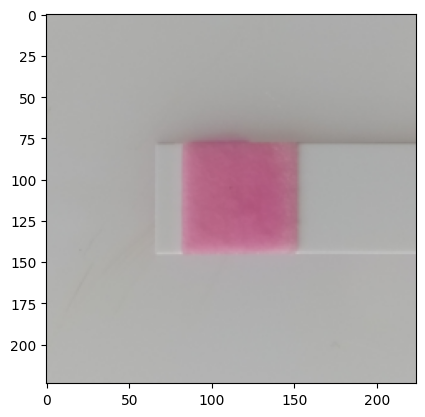

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(dataset.imgs[100])
resizer = transforms.Resize(350)
img = resizer.forward(img)
cropper = transforms.CenterCrop(224)
img = cropper.forward(img)
img = np.array(img)
# dataset.imgs[100]
plt.imshow( img )